# Zadanie - *Interpretability* - Mateusz Sperkowski

Zadanie interpretowalności w sieciach neuronowych jest coraz ważniejsze, wraz z coraz częstszym z wprowadzaniem modeli do produkcji, oraz coraz większą odpowiedzialnością kładzioną na nich. Ułatwienie zrozumienia na podstawie czego dana sieci tworzy swoje predykcje umożliwia wykrycie i poprawienie stronniczości modelu, jak i innych błędów. W artykule (Teach, Randy L., and Edward H. Shortliffe. "An analysis of physician attitudes regarding computer-based clinical consultation systems." Computers and Biomedical Research 14.6 (1981): 542-558.) wyjaśnienie decyzji wsparcia komputerowego zostało uznane przez lekarzy za najważniejszą funkcję, co jest łatwo zrozumiałe biorąc pod uwagę jak dużą opowiedzialność ponoszą w swojej dziedzinie.

## VGG19 
Sieć ta została stworzona w ramach artykułu (Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014), https://arxiv.org/abs/1409.1556). Przedstawia ona zastosowanie bardzo głębokiej sieci konwolucyjnej (19 warstw, stąd nazwa VGG19), osiągającej lepsze wyniki niż ówczesne 'state of the art', czyli najlepsze modele. Artykuł został napisany na rzecz uczestnictwa autorów w ImageNet 2014 Challenge, gdzie zdobyli 1 i 2 miejsce odpowiednio w zadaniu lokalizacji i klasyfikacji. Dodatkowo sieć ta według autorów jest generalizowalna do innych zbiorów danych niż ImageNet.

Wykonane wzorując się na notebook'u z zajęć: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb
(https://keras.io/examples/vision/grad_cam/)

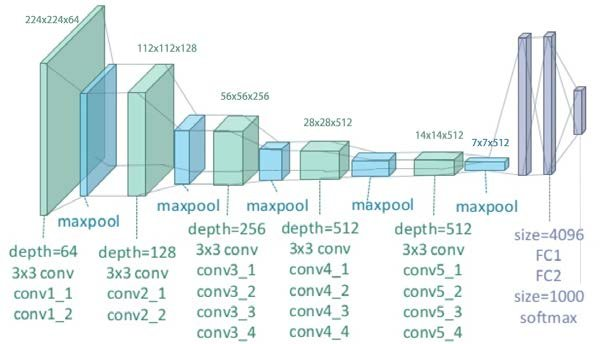

In [35]:
#Source: https://www.researchgate.net/figure/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_fig2_325137356
display(Image("vgg19.jpg", width=800))

In [9]:
pip install lime

In [10]:
import tensorflow as tf
import keras
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.preprocessing import image
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

In [11]:
model = VGG19(weights='imagenet')

In [12]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
def preprocess_image(path):
  img = image.load_img(path=path, target_size=(224, 224))
  img_processed = image.img_to_array(img)
  img_processed = np.expand_dims(img_processed, axis=0)
  img_processed = preprocess_input(img_processed)
  return img_processed

Postanowiłem skupić się na sprawdzeniu wynikow dla różnych zdjęć 
axolotlów, jak i w przypadku błędnej predykcji porównianiu ich z wynikiem dla zwierzęcia z wspomnianej błędnej predykcji. Dzięki metodom XAI powinno ułatwić nam zauważenie czemu w tym przypadku wyszedł błędny wynik.

Źródła zdjęć: 

https://www.library.pima.gov/wp-content/uploads/sites/6/2017/10/gila-monster.jpg

https://commons.wikimedia.org/wiki/File:Axolotl_ganz.jpg

https://www.everythingreptiles.com/types-of-axolotl-colors/

https://nbc-2.com/wp-content/uploads/2020/09/green-iguana-1024x576.jpg

## GRAD-CAM Explanation

In [14]:
# fchollet 's code, barely edited (image display)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image(cam_path, width=600))

In [15]:
#My code
def preprocess_show_predict_gradcam(path):
  display(Image(path, width=600))

  img_processed = preprocess_image(path)
  pred = model.predict(img_processed)
  pred_print = [(i[1], i[2]) for i in decode_predictions(pred)[0]]
  print('Prediction:', pred_print)
  heatmap = make_gradcam_heatmap(img_processed, model, 'block5_conv4')
  print(f"GRAD-CAM explanation for top prediction with label: {decode_predictions(pred)[0][0][1]}")
  save_and_display_gradcam(path, heatmap)
  return

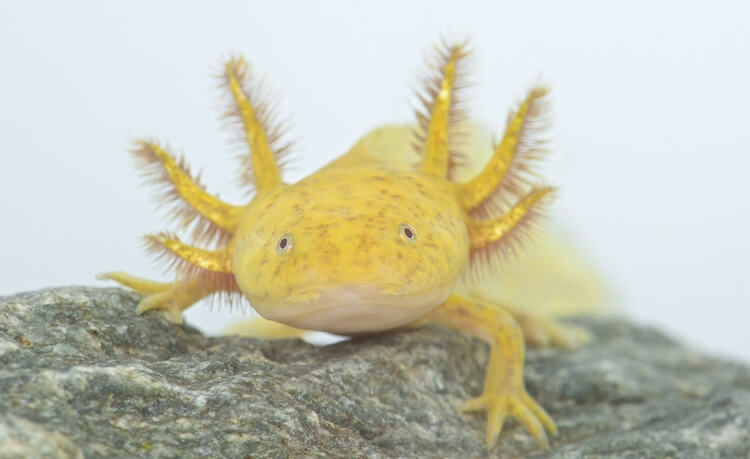

40960/35363 [==================================] - 0s 0us/step
Prediction: [('axolotl', 0.9971282), ('common_newt', 0.0014922223), ('eft', 0.00066406355), ('goldfish', 0.00046636304), ('banded_gecko', 5.370691e-05)]
GRAD-CAM explanation for top prediction with label: axolotl


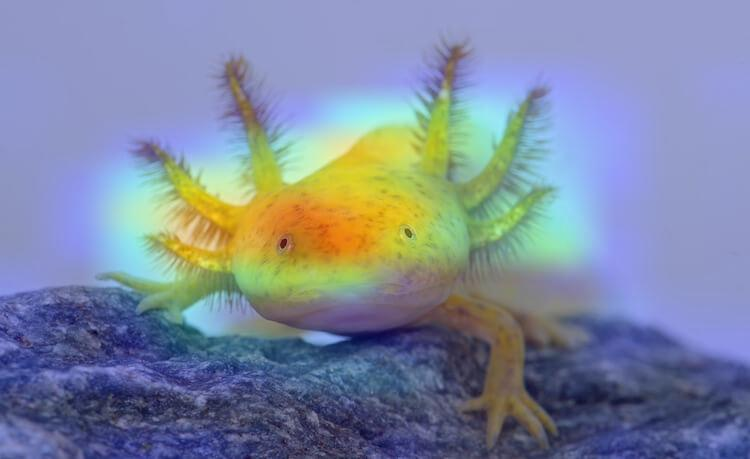

In [16]:
#Prediction here was correct
preprocess_show_predict_gradcam("Golden-Axolotl.jpg")

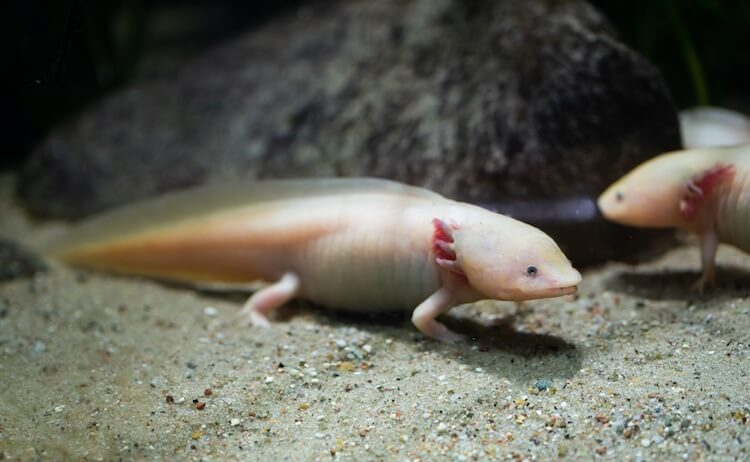

Prediction: [('axolotl', 0.99568766), ('tench', 0.0019949717), ('armadillo', 0.00059354916), ('snail', 0.00030347347), ('eel', 0.00020252043)]
GRAD-CAM explanation for top prediction with label: axolotl


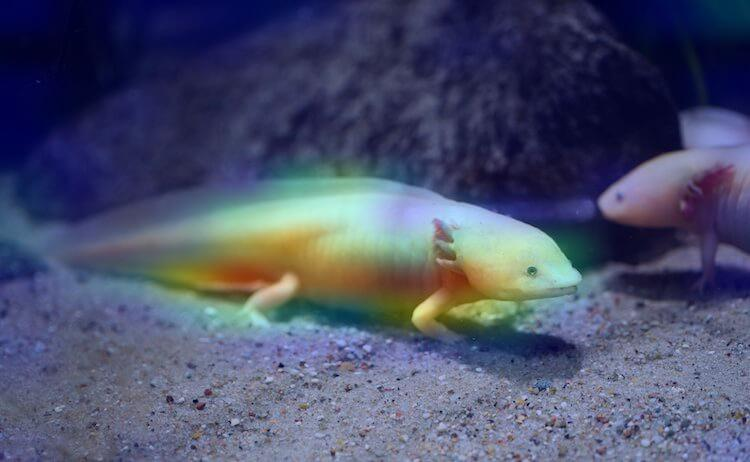

In [17]:
#Prediction here was correct
preprocess_show_predict_gradcam("Albino-Axolotl.jpg")

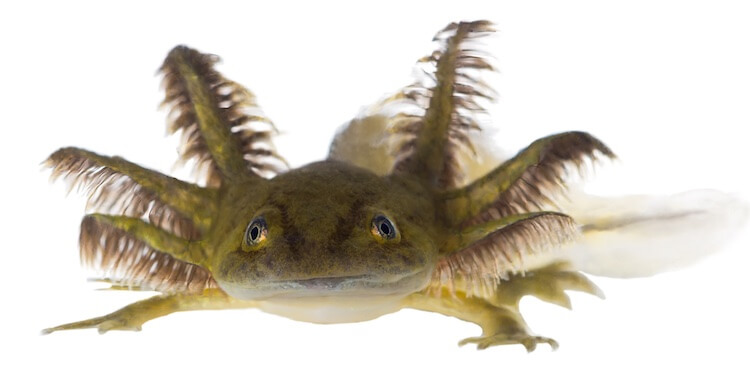

Prediction: [('axolotl', 0.48626557), ('African_chameleon', 0.09947151), ('triceratops', 0.09438373), ('common_iguana', 0.06738878), ('common_newt', 0.036317687)]
GRAD-CAM explanation for top prediction with label: axolotl


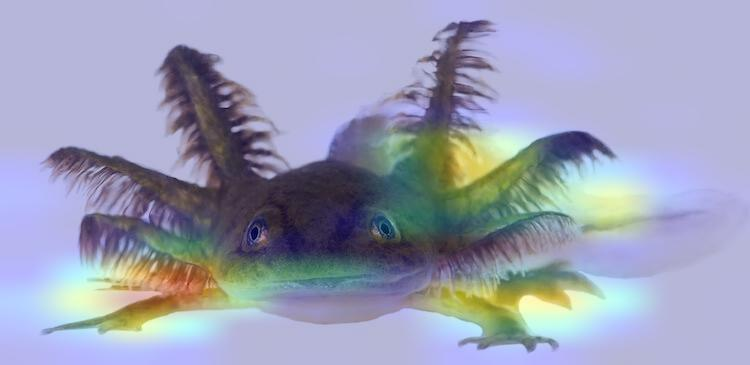

In [18]:
#Prediction here was correct
preprocess_show_predict_gradcam("/content/Copper-Axolotl.jpg")

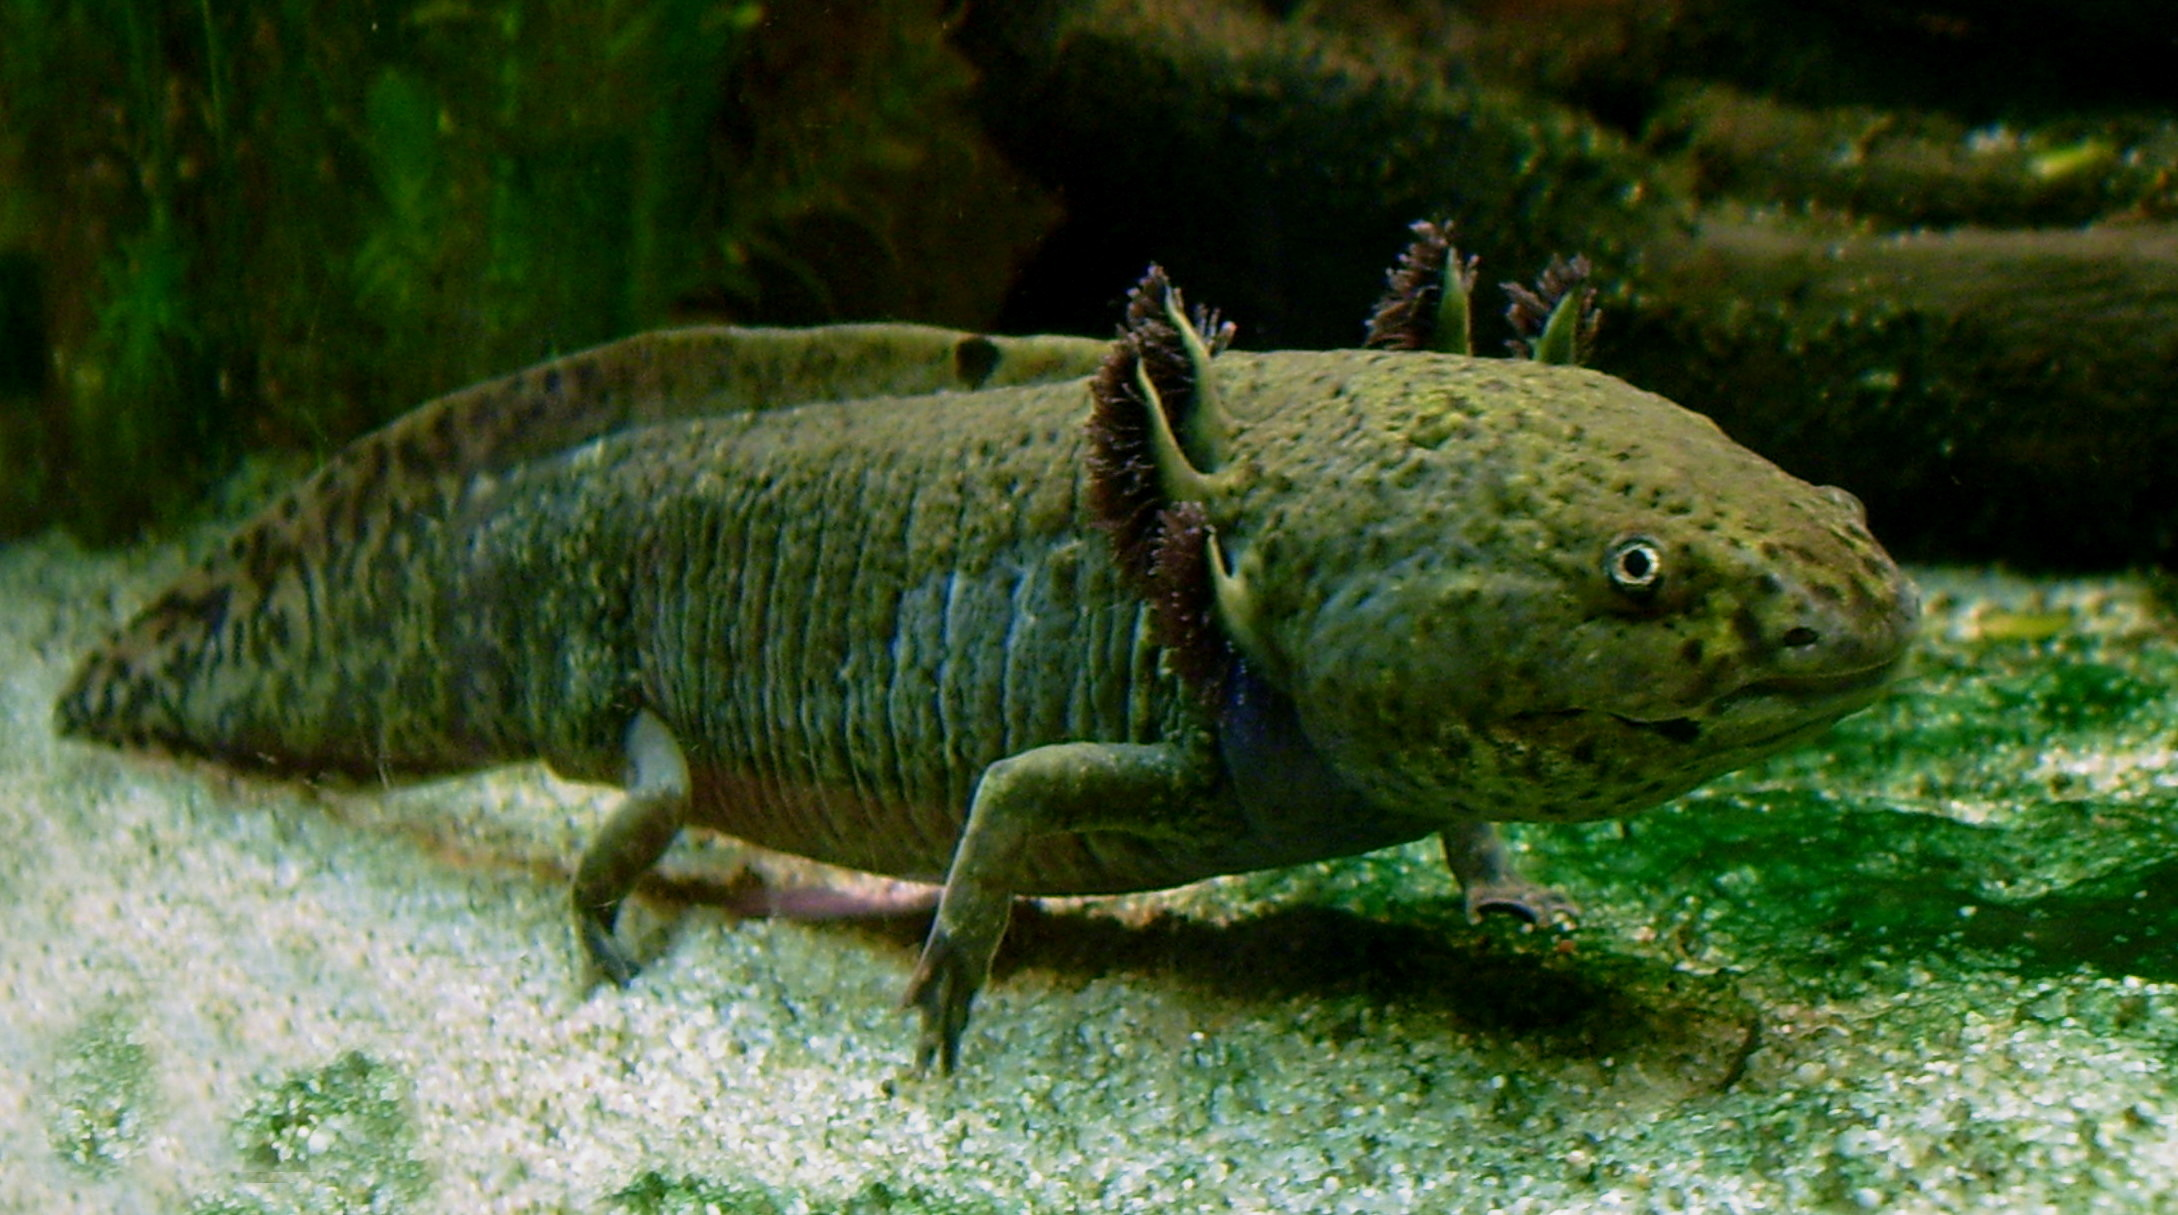

Prediction: [('African_chameleon', 0.9539452), ('axolotl', 0.01084041), ('Komodo_dragon', 0.004871922), ('common_iguana', 0.0042682844), ('loggerhead', 0.0024411317)]
GRAD-CAM explanation for top prediction with label: African_chameleon


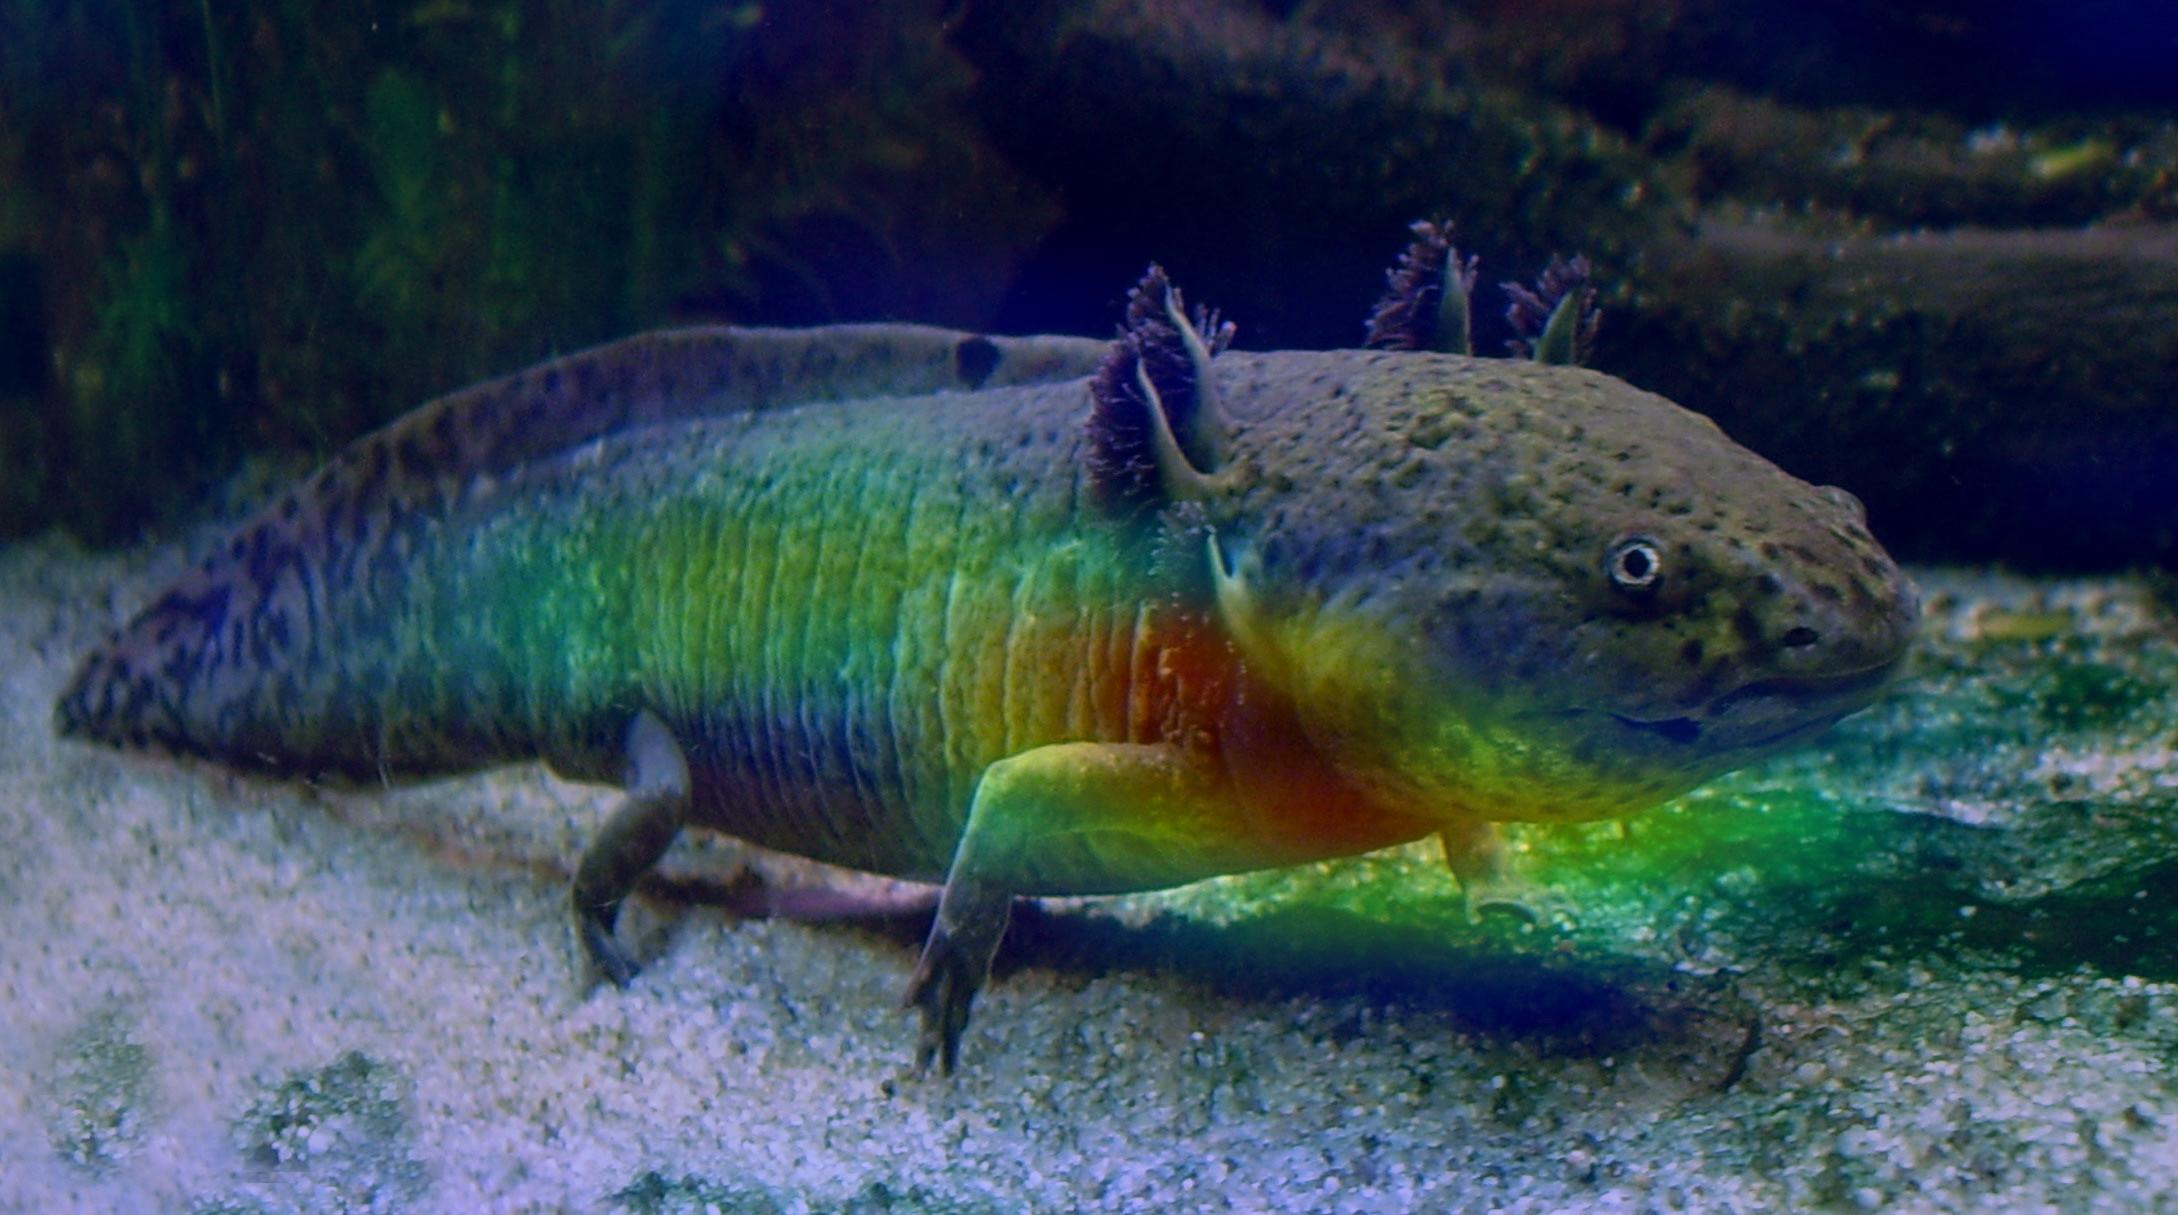

In [19]:
#Prediction here was incorrect
preprocess_show_predict_gradcam('Axolotl_ganz.jpg')

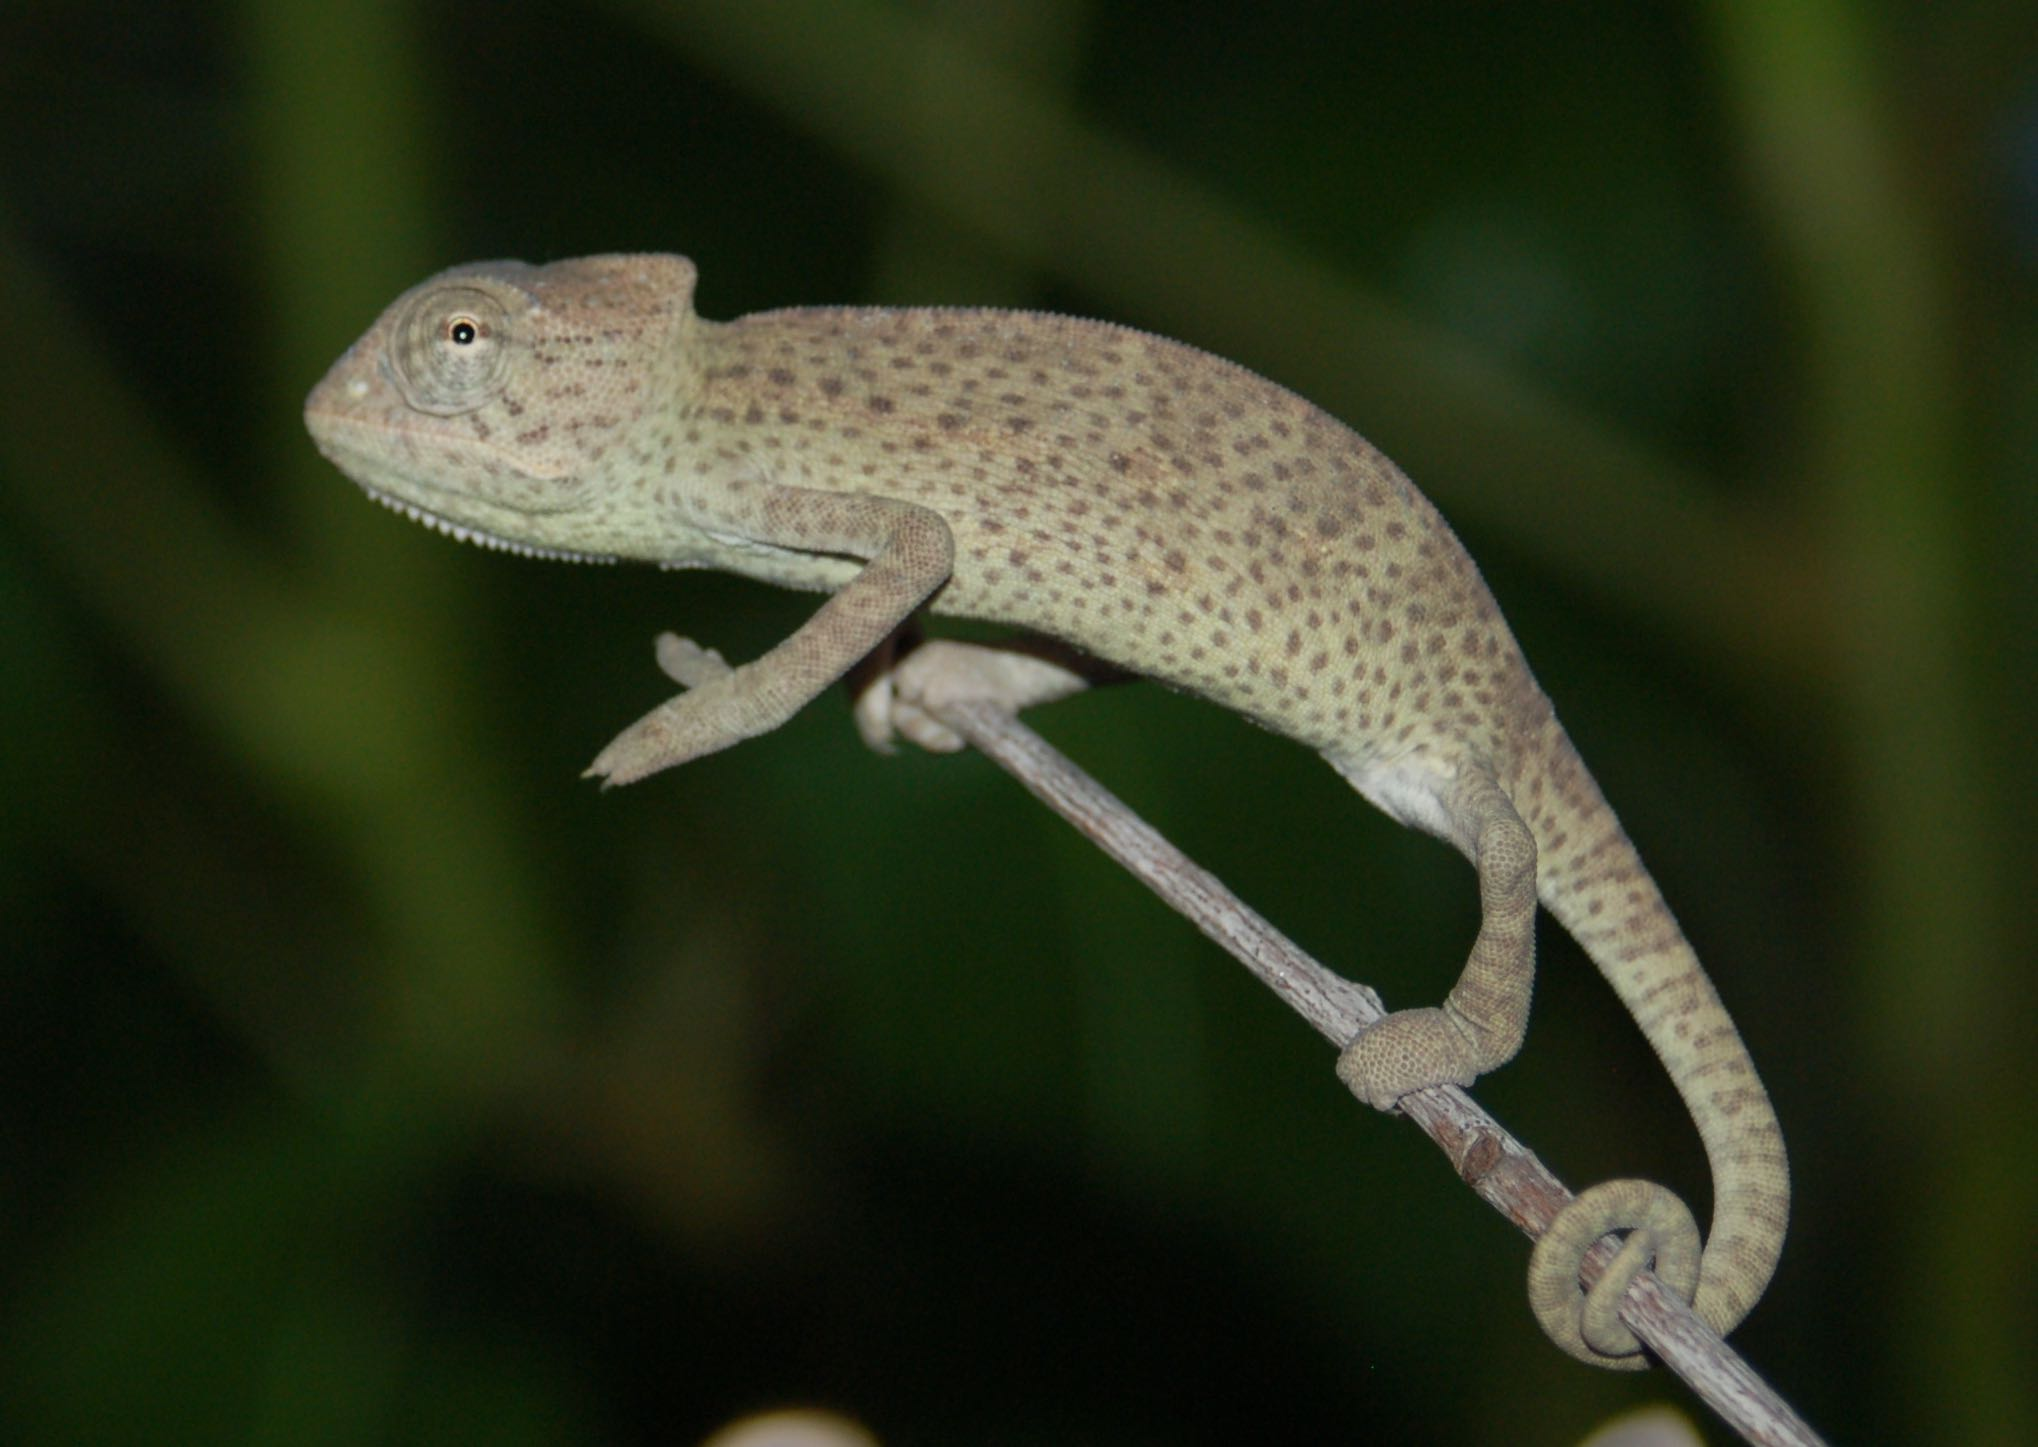

Prediction: [('African_chameleon', 0.6916741), ('American_chameleon', 0.07128341), ('banded_gecko', 0.06285131), ('agama', 0.054421607), ('green_lizard', 0.037407383)]
GRAD-CAM explanation for top prediction with label: African_chameleon


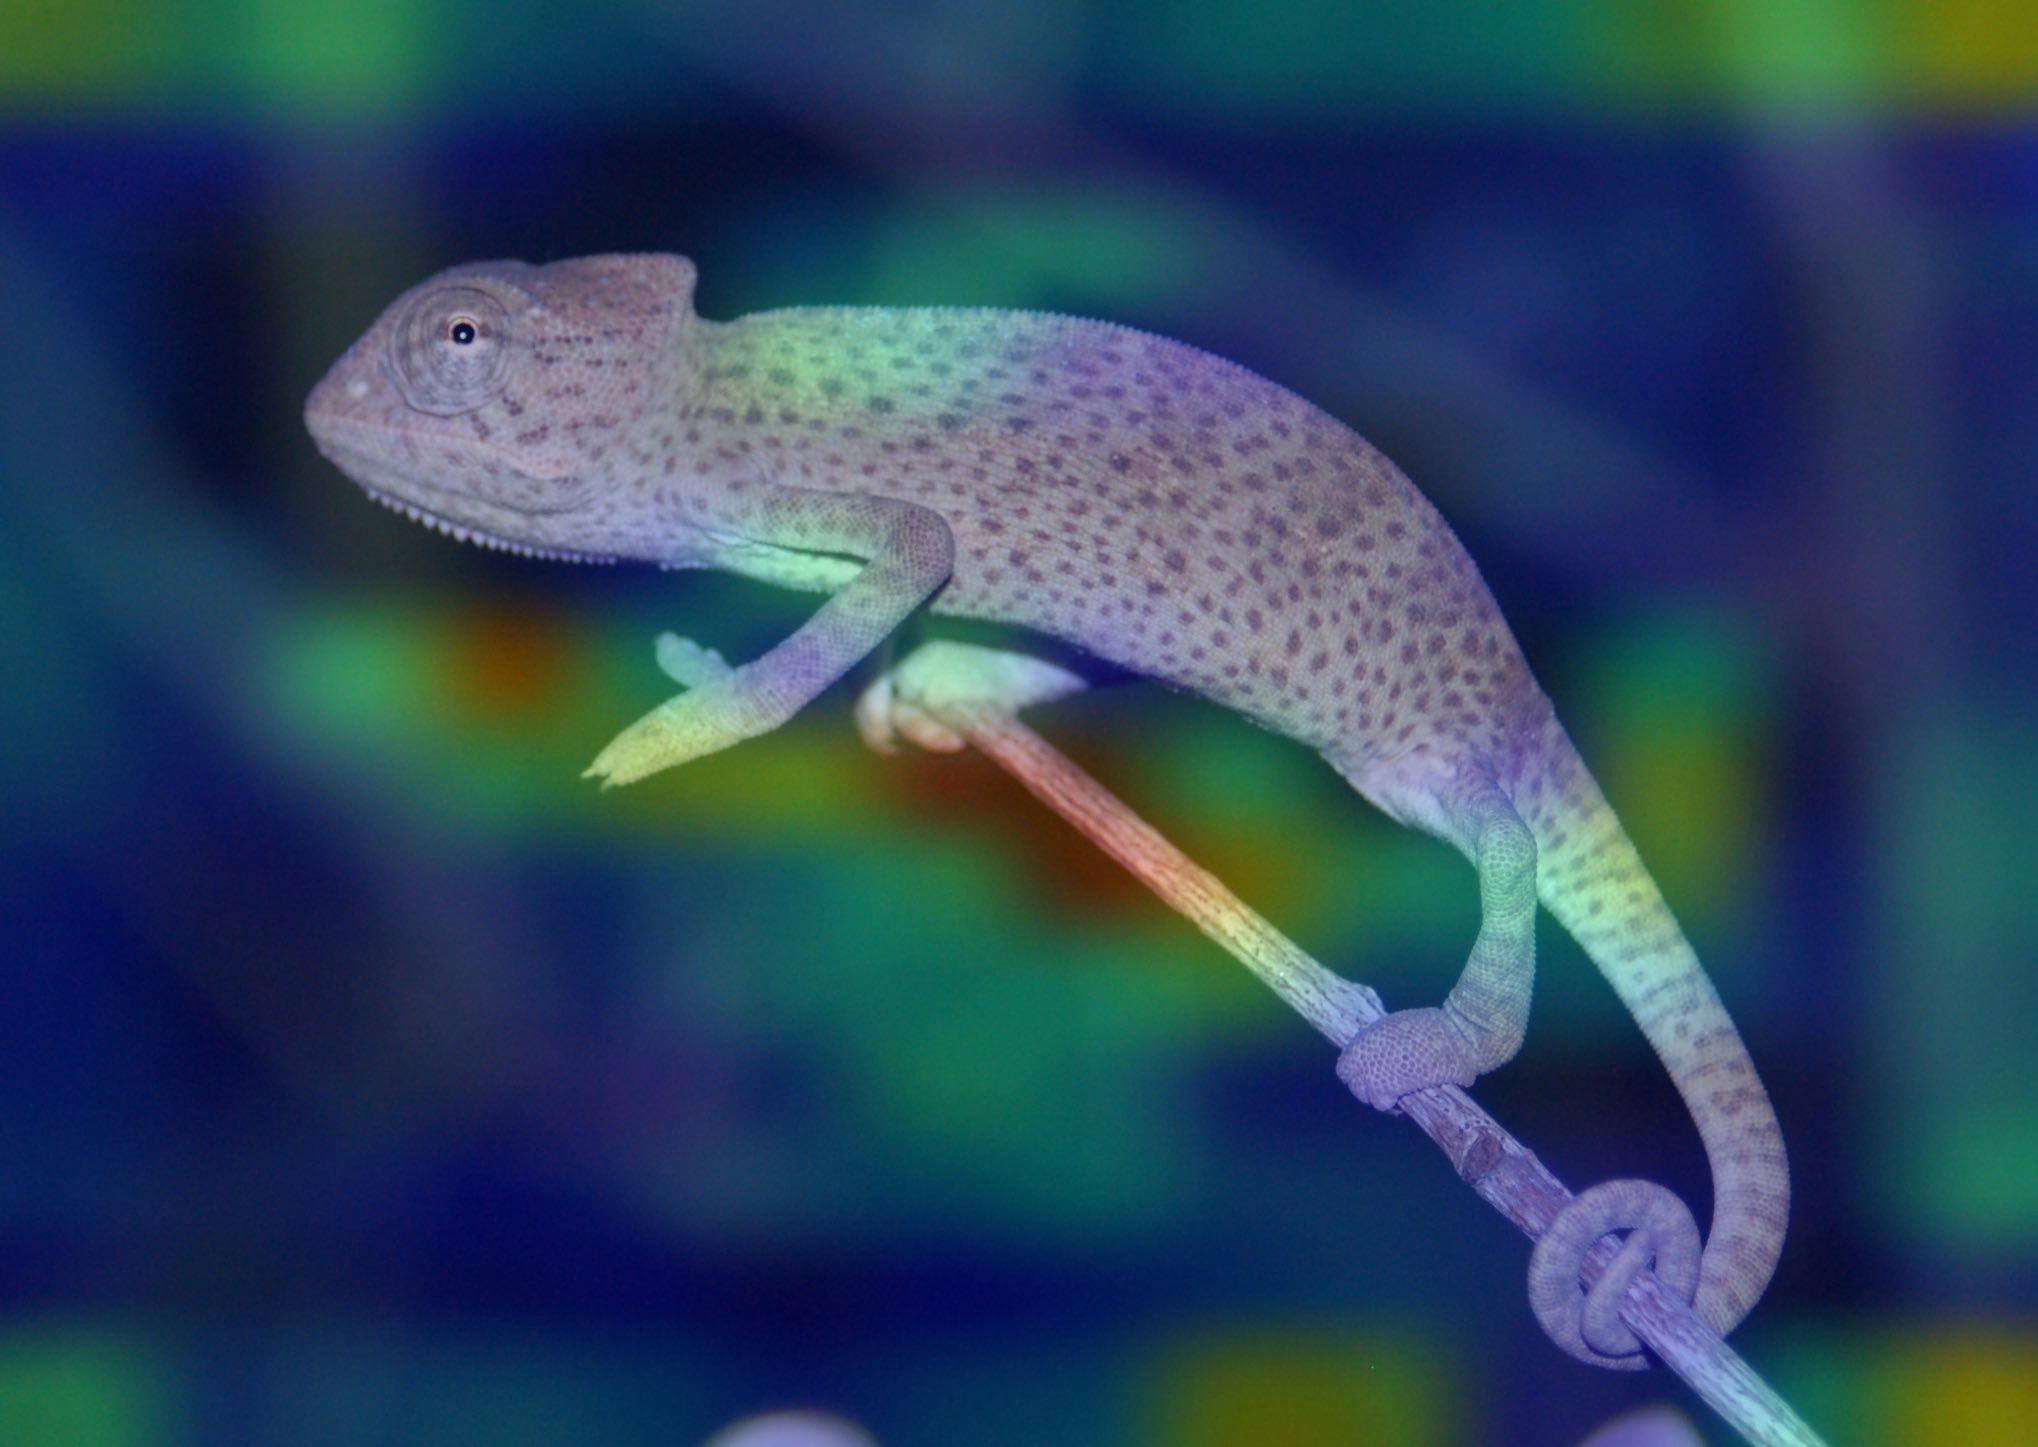

In [20]:
#Prediction here was incorrect
preprocess_show_predict_gradcam("/content/African-Chameleon.jpg")

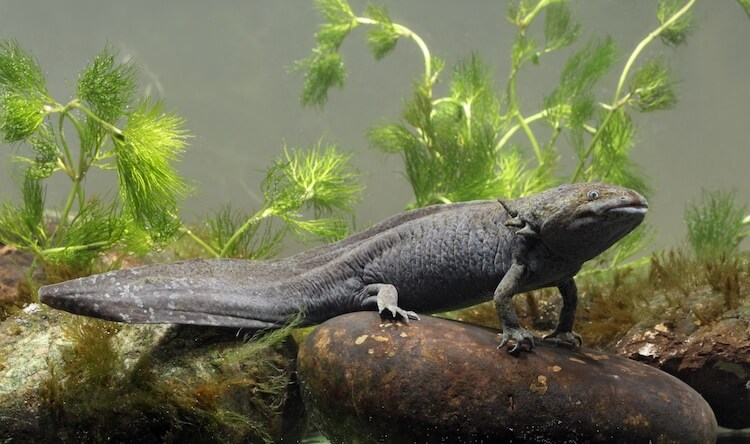

Prediction: [('common_iguana', 0.380437), ('Komodo_dragon', 0.24515142), ('American_alligator', 0.14804874), ('terrapin', 0.06035724), ('axolotl', 0.05518603)]
GRAD-CAM explanation for top prediction with label: common_iguana


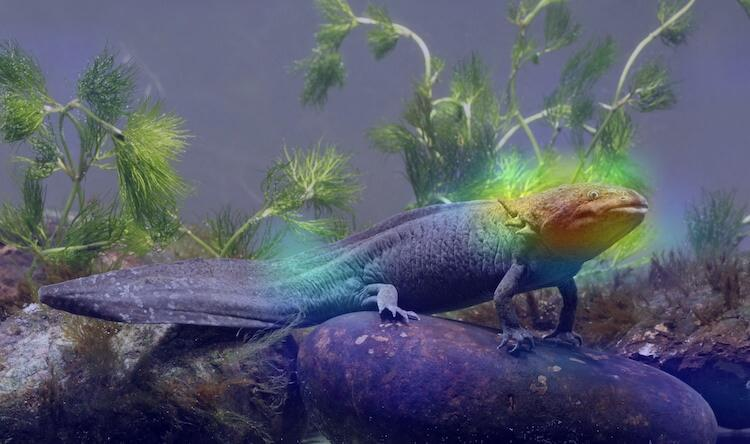

In [21]:
#Prediction here was incorrect
preprocess_show_predict_gradcam("Black-Melanoid-Axolotl-In-An-Aquarium.jpg")

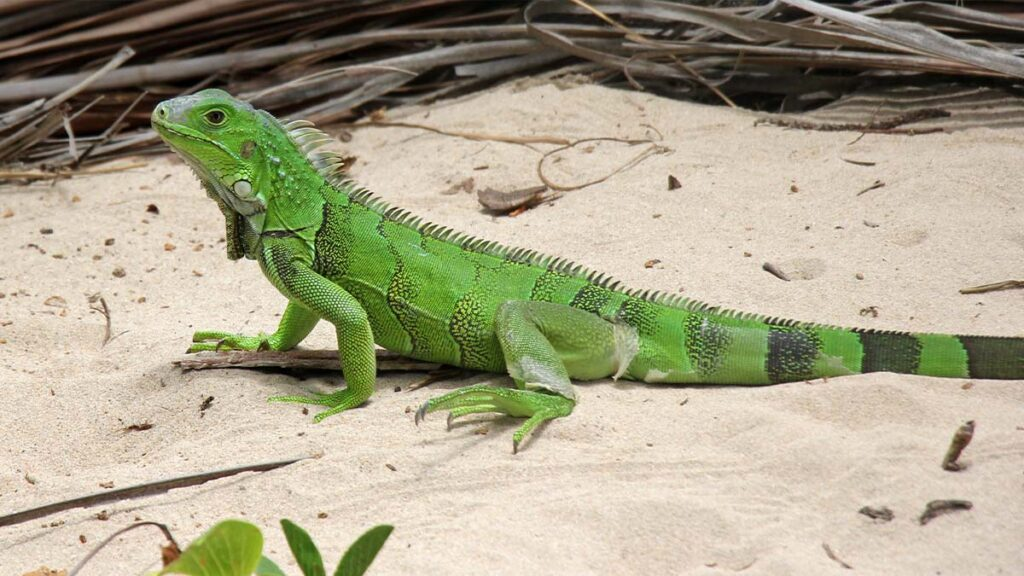

Prediction: [('green_lizard', 0.6109531), ('common_iguana', 0.37646976), ('agama', 0.004686766), ('American_chameleon', 0.0038779508), ('whiptail', 0.0020444721)]
GRAD-CAM explanation for top prediction with label: green_lizard


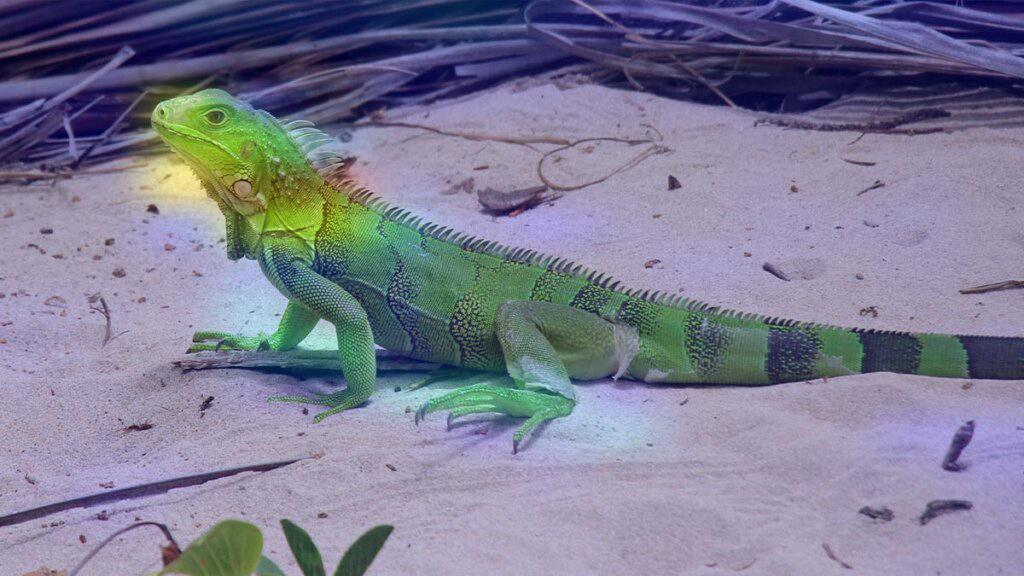

In [22]:
#Prediction here was correct, given for comparison
preprocess_show_predict_gradcam("/content/green-iguana-1024x576.jpg")

## LIME Explanation

Following this tutorial: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [31]:
explainer = lime_image.LimeImageExplainer()
def lime_explain(path):
  img = preprocess_image(path)[0]
  explanation = explainer.explain_instance(img.astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)
  print(explanation.top_labels[0])
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,15))
  img = image.load_img(path=path, target_size=(224, 224))
  img_processed = image.img_to_array(img)/255
  ax1.imshow(img)
  ax1.title.set_text('Processed Img')
  ax1.set_axis_off()
  ax2.imshow(mark_boundaries(temp/2+0.5, mask))
  ax2.title.set_text('Explanation')
  ax2.set_axis_off()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46


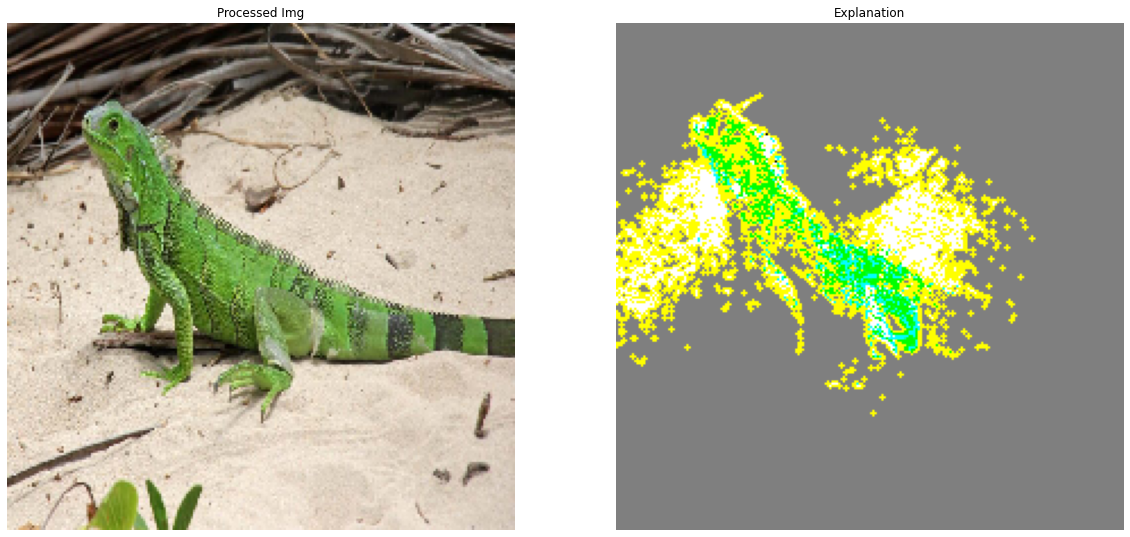

In [32]:
#Prediction here was correct, for comparison with axolotl below
img_path = "/content/green-iguana-1024x576.jpg"
lime_explain(img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


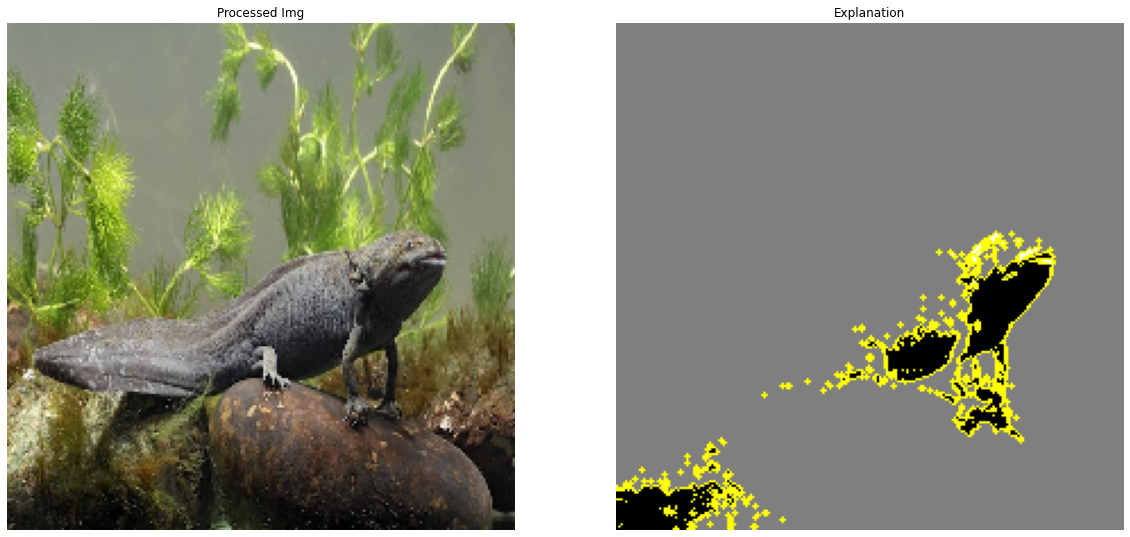

In [25]:
#Prediction here was incorrect, top prediction 'common_iguana': 38.04367%, axolotol as its 5th prediction 'axolotl': 5.518615%
img_path = "Black-Melanoid-Axolotl-In-An-Aquarium.jpg"
lime_explain(img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


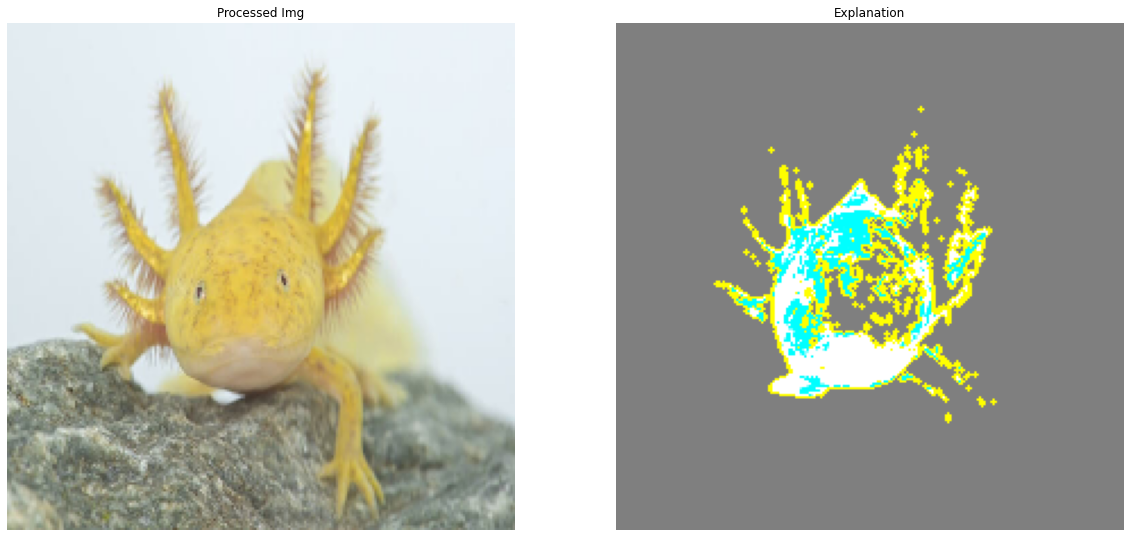

In [26]:
#Prediction here was correct
img_path = "Golden-Axolotl.jpg"
lime_explain(img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29


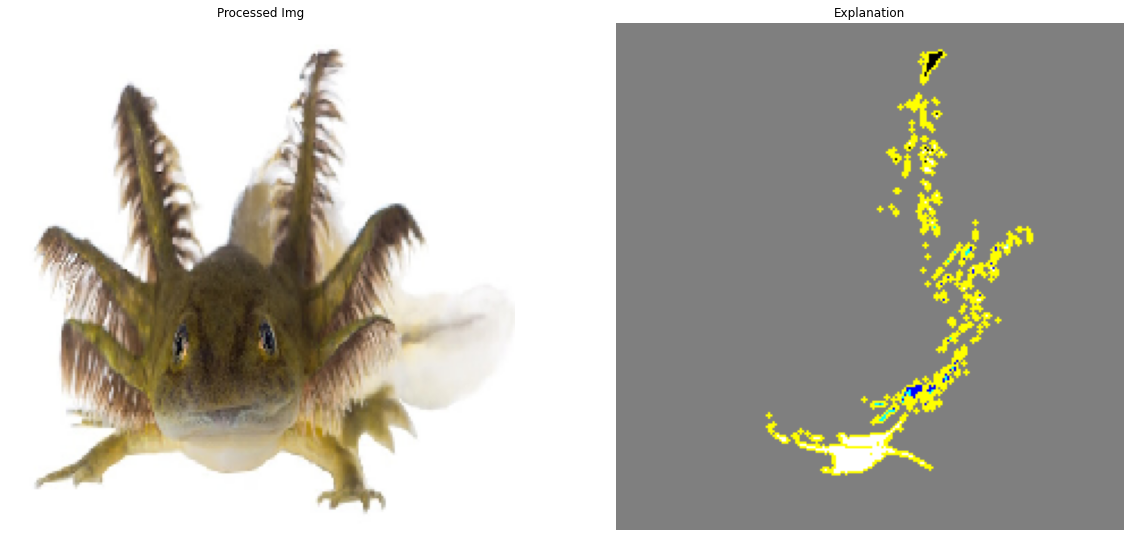

In [44]:
#Prediction here was correct but with very low confidence. for comparison with the one above
img_path = "/content/Copper-Axolotl.jpg"
lime_explain(img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


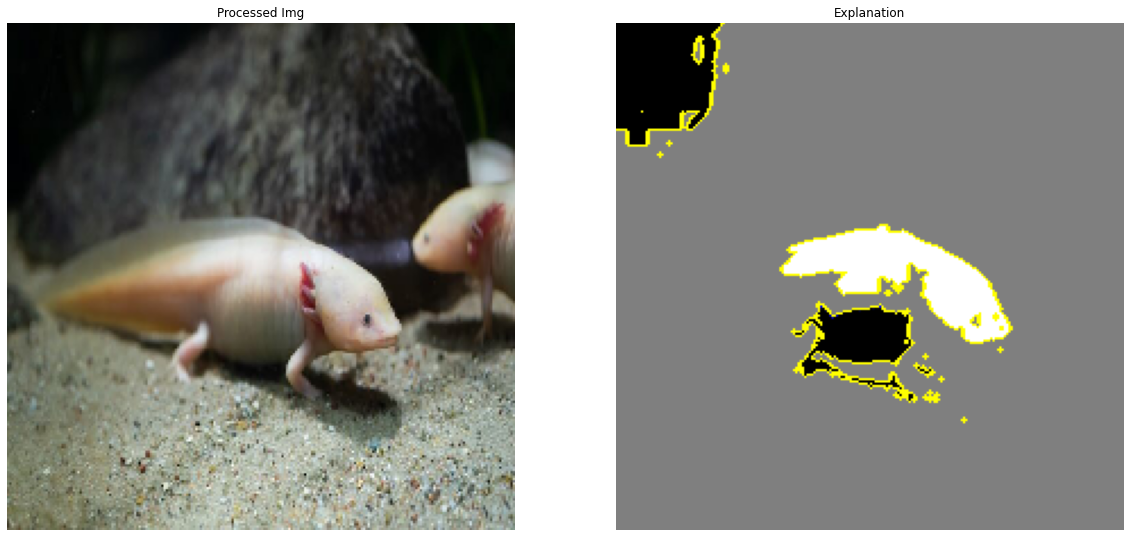

In [28]:
#Prediction here was correct, for comparison with the axolotl below
img_path = "Albino-Axolotl.jpg"
lime_explain(img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


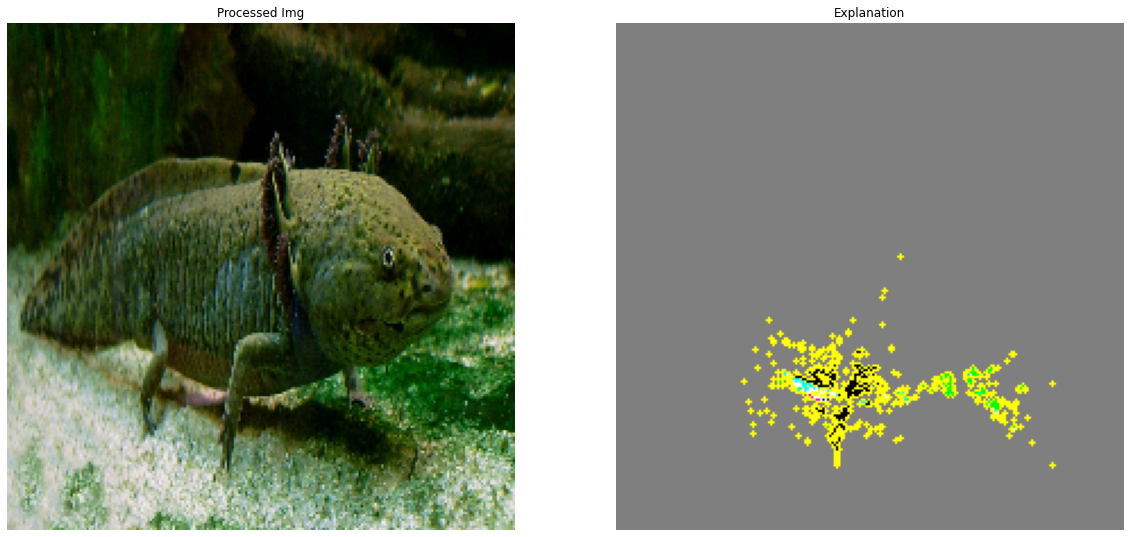

In [29]:
#Prediction here was incorrect, top prediction 'African_chameleon': 95.39452%, second prediction 'axolotl': 1.0840442%
img_path = 'Axolotl_ganz.jpg'
lime_explain(img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


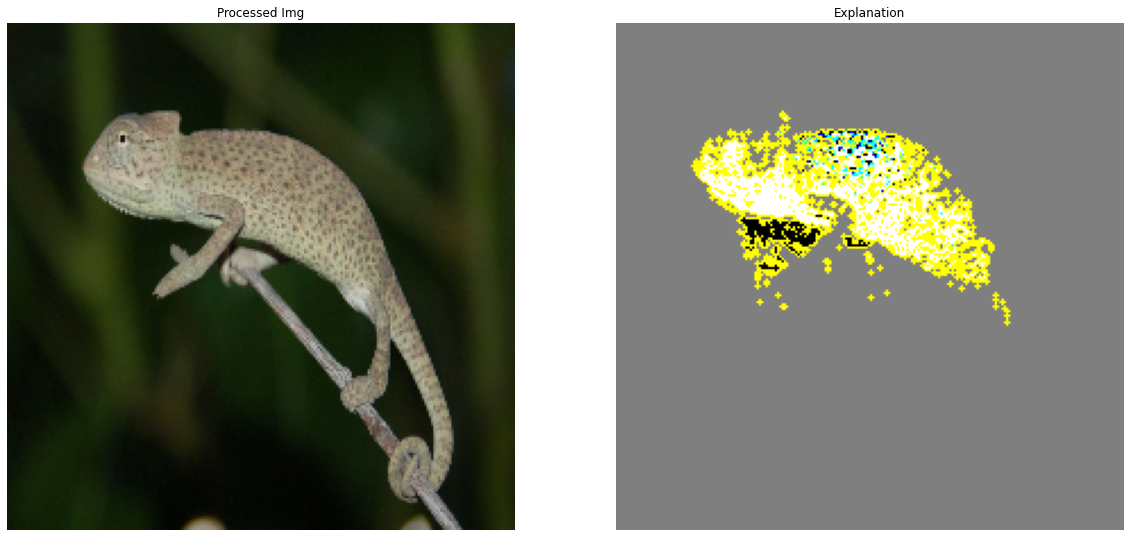

In [30]:
#Prediction here was correct, comparison to axolotl above
img_path = "/content/African-Chameleon.jpg"
lime_explain(img_path)

## Wnioski

Mozliwe ze za wyniki niepoprawne odpowiadaja rzadsze warianty kolorystyki i ułożenia ciała. Uważam, że prawdopodobnie istnieje 'bias', gdzie w wypadku zwierząt większość zdjęć robi się w podobnych ułożeniach ciał osobników z tego gatunku. Na przykładzie axolotla, często zdjecie robi się z frontu, więc bardzo możliwe że w zbiorze treningowym jest duża ilość danych właśnie takich, czysto z powodu dostępu do fotografii. Również ubarwienie różni się znacznie, gdzie część ubarwień jest rzadsza od innych. Może to mieć istotny wpływ na wynik sieci, a niestandardowe ułożenia mogą powodować przypisanie do innej kategorii. Oczywiście idea tego problemu przenosi się na wszystkie możliwe cele klasyfikacji zdjęć. Być może za pomocą bardzo zaawansowanych metod 'Data Augmentation' (Mikołajczyk, Agnieszka, and Michał Grochowski. "Data augmentation for improving deep learning in image classification problem." 2018 international interdisciplinary PhD workshop (IIPhDW). IEEE, 2018.) możliwe byłoby częściowe rozwiązanie tego problemu.

Wyjaśnianie modelów predykcji zdjęć, daje nam względnie zrozumiałe dla człowieka spojrzenie na podjętą decyzję. 